In [1]:
from disk_utils_jax import jax_model
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
from jax import jit
import numpy as np

jax.config.update("jax_enable_x64", False)


KNOTS = 10

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 40. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

disk_params2 = {}
disk_params2['inclination'] = 60. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

## Creating Image Models

In [3]:

# DHG parameters
spf_params = {'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

# Initial spline guess
init_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
x = np.linspace(np.cos(0), np.cos(np.pi), KNOTS)
y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, x)

# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params = disk_params1, spf_params = y)
end = datetime.now()
time1 = end-start
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params2, spf_params = spf_params)
end = datetime.now()
print(end-start)

0:00:06.971141
0:00:04.485459


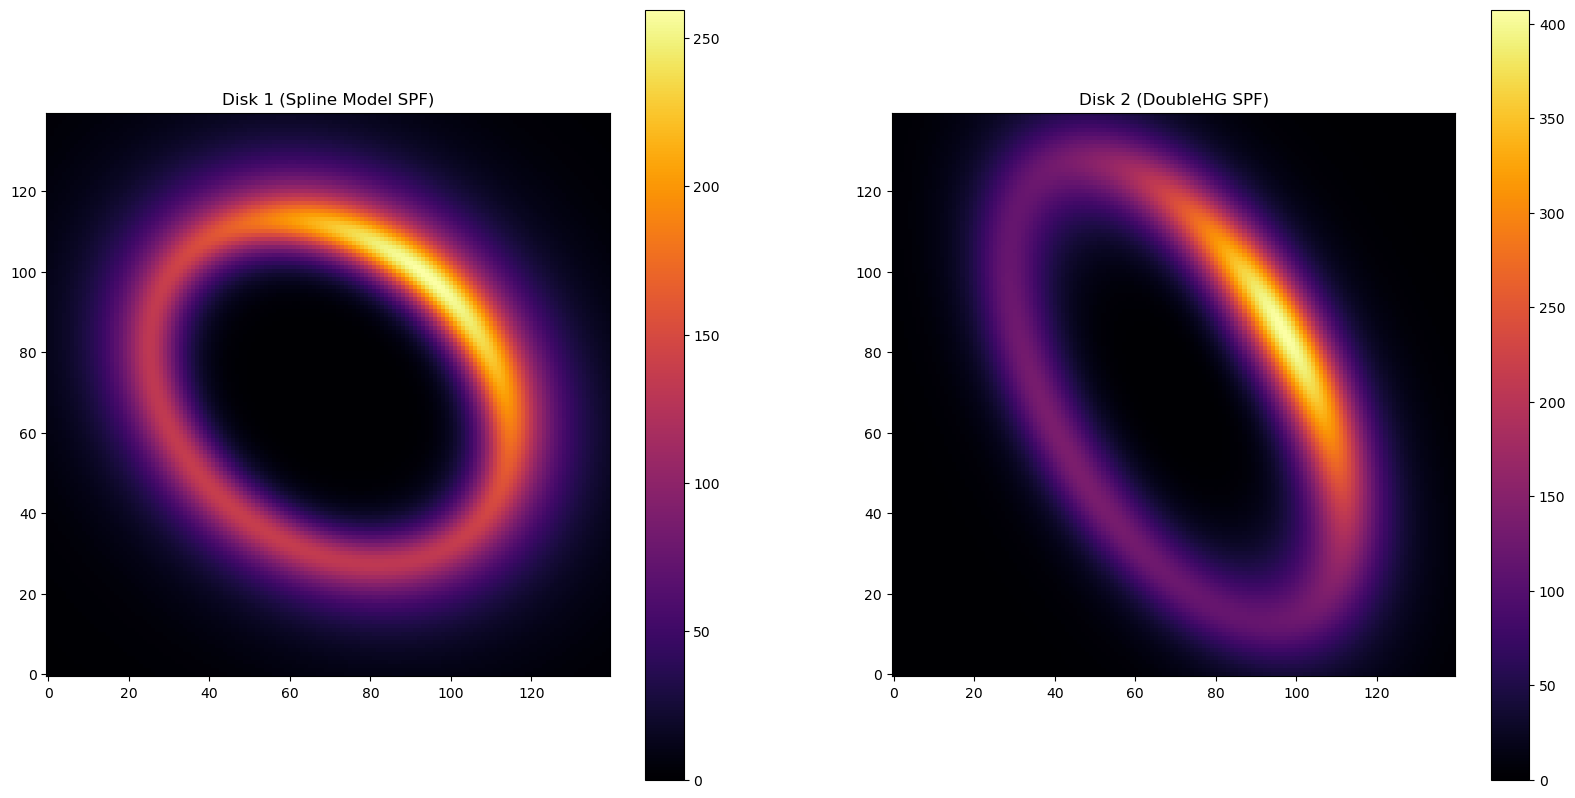

In [4]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Spline Model SPF)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (DoubleHG SPF)")
plt.colorbar(im,ax=axes[1])

### Testing Runtimes

In [5]:
def test_spline_function():
    jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params = disk_params1, spf_params = y)

def test_DHG_function():
    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params1, spf_params = spf_params)

In [6]:
'''%timeit test_spline_function()
%timeit test_DHG_function()'''

'%timeit test_spline_function()\n%timeit test_DHG_function()'

## Optimizing with Spline Models

In [7]:
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

# initial spline guess
init_spf_params = {'g1': 0.5, 'g2': -0.5, 'weight': 0.5}
init_spf = DoubleHenyeyGreenstein_SPF.init([init_spf_params['g1'], init_spf_params['g2'], init_spf_params['weight']])
x = np.linspace(np.cos(0), np.cos(np.pi), KNOTS)
params = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, x)

all_pars = jnp.concatenate((disk_params_1d_jax, params))

In [8]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

target_image = disk_image2+noise

In [9]:
from regression import log_likelihood_1d_pos_all_pars, log_likelihood_1d_pos_all_pars_spline
from scipy.optimize import minimize

In [10]:
llp = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                    disk_params2["flux_scaling"], target_image, jnp.ones(disk_image2.shape)*noise_level)

def convert_to_dict(disk_params, flux_scaling=1e6):
    disk_dict = {}
    disk_dict['inclination'] = disk_params[3]
    disk_dict['position_angle'] = disk_params[4]
    disk_dict['alpha_in'] = disk_params[0]
    disk_dict['alpha_out'] = disk_params[1]
    disk_dict['flux_scaling'] = flux_scaling
    disk_dict['sma'] = disk_params[2]
    return disk_dict

In [11]:
no_grad_method = "Nelder-Mead"
soln_nm = minimize(llp, all_pars, method=no_grad_method)
disk_fit_nm = convert_to_dict(soln_nm.x)

opt = {'disp':True,'maxiter':500}
soln_go = minimize(llp, all_pars, options=opt, method = None)
disk_fit_go = convert_to_dict(soln_go.x)

print(soln_nm)

         Current function value: 97899.500000
         Iterations: 3
         Function evaluations: 1201
         Gradient evaluations: 70
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 86662.8515625
             x: [ 5.094e+00 -6.718e+00 ...  5.222e-02  1.454e-01]
           nit: 2283
          nfev: 3000
 final_simplex: (array([[ 5.094e+00, -6.718e+00, ...,  5.222e-02,
                         1.454e-01],
                       [ 5.099e+00, -6.749e+00, ...,  5.227e-02,
                         1.449e-01],
                       ...,
                       [ 5.103e+00, -6.747e+00, ...,  5.252e-02,
                         1.440e-01],
                       [ 5.077e+00, -6.741e+00, ...,  5.252e-02,
                         1.456e-01]], dtype=float32), array([ 8.666e+04,  8.666e+04, ...,  8.666e+04,  8.666e+04]))


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [12]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm) + str(soln_nm.x[5:]))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_spline(soln_nm.x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
#print("Gradient Optimization Disk Parameters: " + str(disk_fit_go) + str(soln_go.x[5:]))
#print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_spline(soln_go.x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
#                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 60.279915, 'position_angle': 29.859474, 'alpha_in': 5.0936203, 'alpha_out': -6.717798, 'flux_scaling': 1000000.0, 'sma': 40.00013}[0.268256   0.14060223 0.07871909 0.06484239 0.03854606 0.0531837
 0.03327131 0.05632018 0.05222017 0.14535195]
Log-Likelihood: 86662.85
Actual Disk Parameters: {'inclination': 60.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}{'g1': 0.5, 'g2': -0.3, 'weight': 0.7}
Log-Likelihood: 86624.55


In [13]:
disk_fit_nm = convert_to_dict(soln_nm.x[0:5])
spf_params_nm = soln_nm.x[5:]

disk_fit_go = convert_to_dict(soln_go.x[0:5])
spf_params_go = soln_go.x[5:]

disk_image1_ap = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_params1, spf_params=params)

disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_fit_nm,
                               spf_params=spf_params_nm)
disk_image_fit_go = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_fit_go,
                               spf_params=spf_params_go)

Text(0.5, 1.0, 'Grad Optimized Disk')

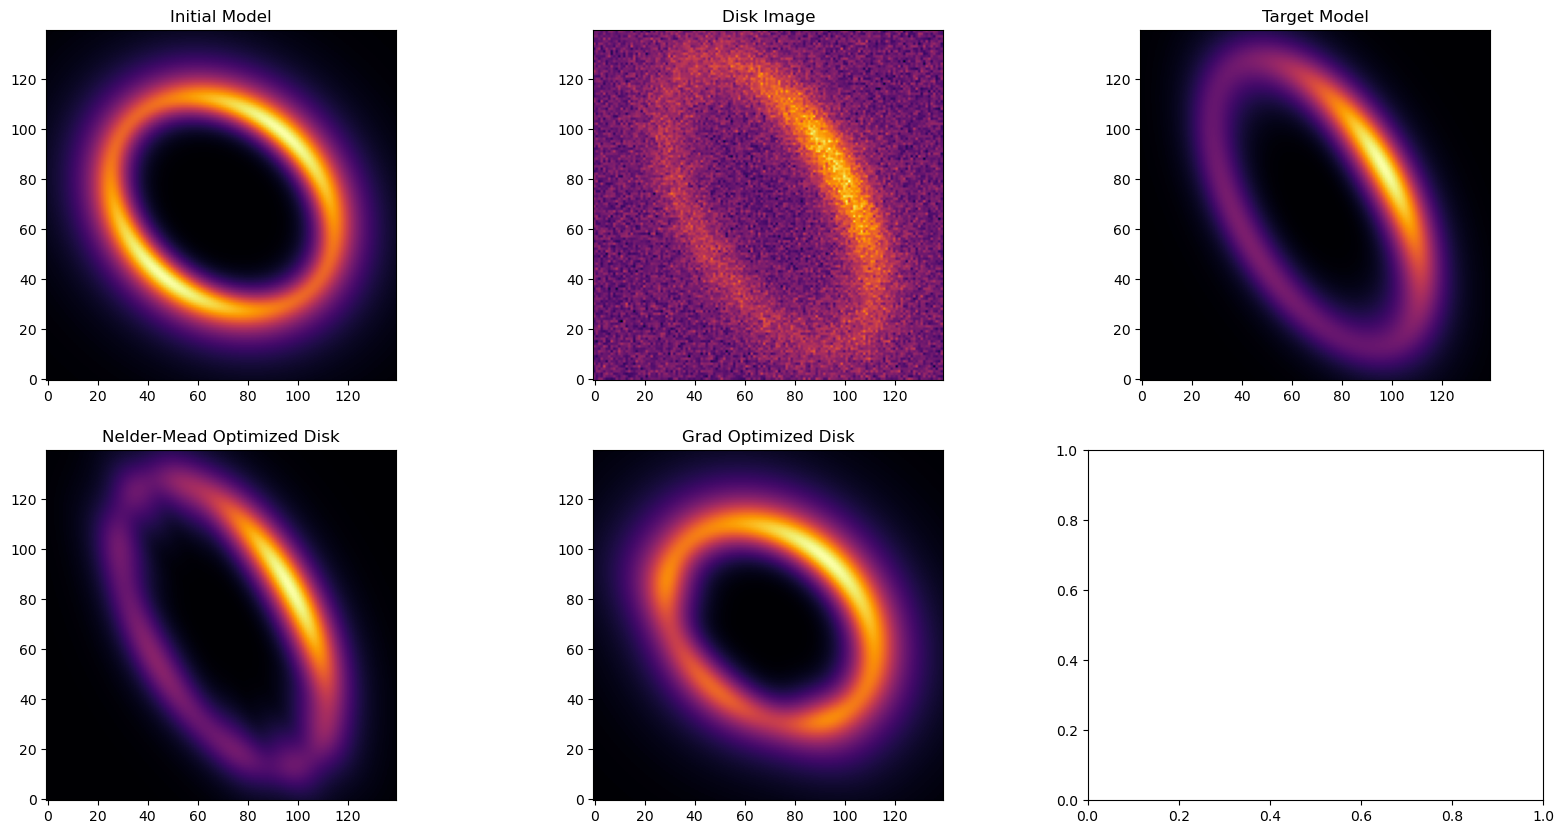

In [14]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

axes[0][0].imshow(disk_image1_ap, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[0][2].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0][2].set_title("Target Model")

axes[1][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[1][0].set_title("Nelder-Mead Optimized Disk")

axes[1][1].imshow(disk_image_fit_go, origin='lower', cmap='inferno')
axes[1][1].set_title("Grad Optimized Disk")

In [15]:
def nelder_mead_test():
    soln = minimize(llp, all_pars, method="Nelder-Mead")
    
def gradient_optimization_test():
    soln = minimize(llp, all_pars, method=None)

In [16]:
#%timeit nelder_mead_test()
#%timeit gradient_optimization_test()

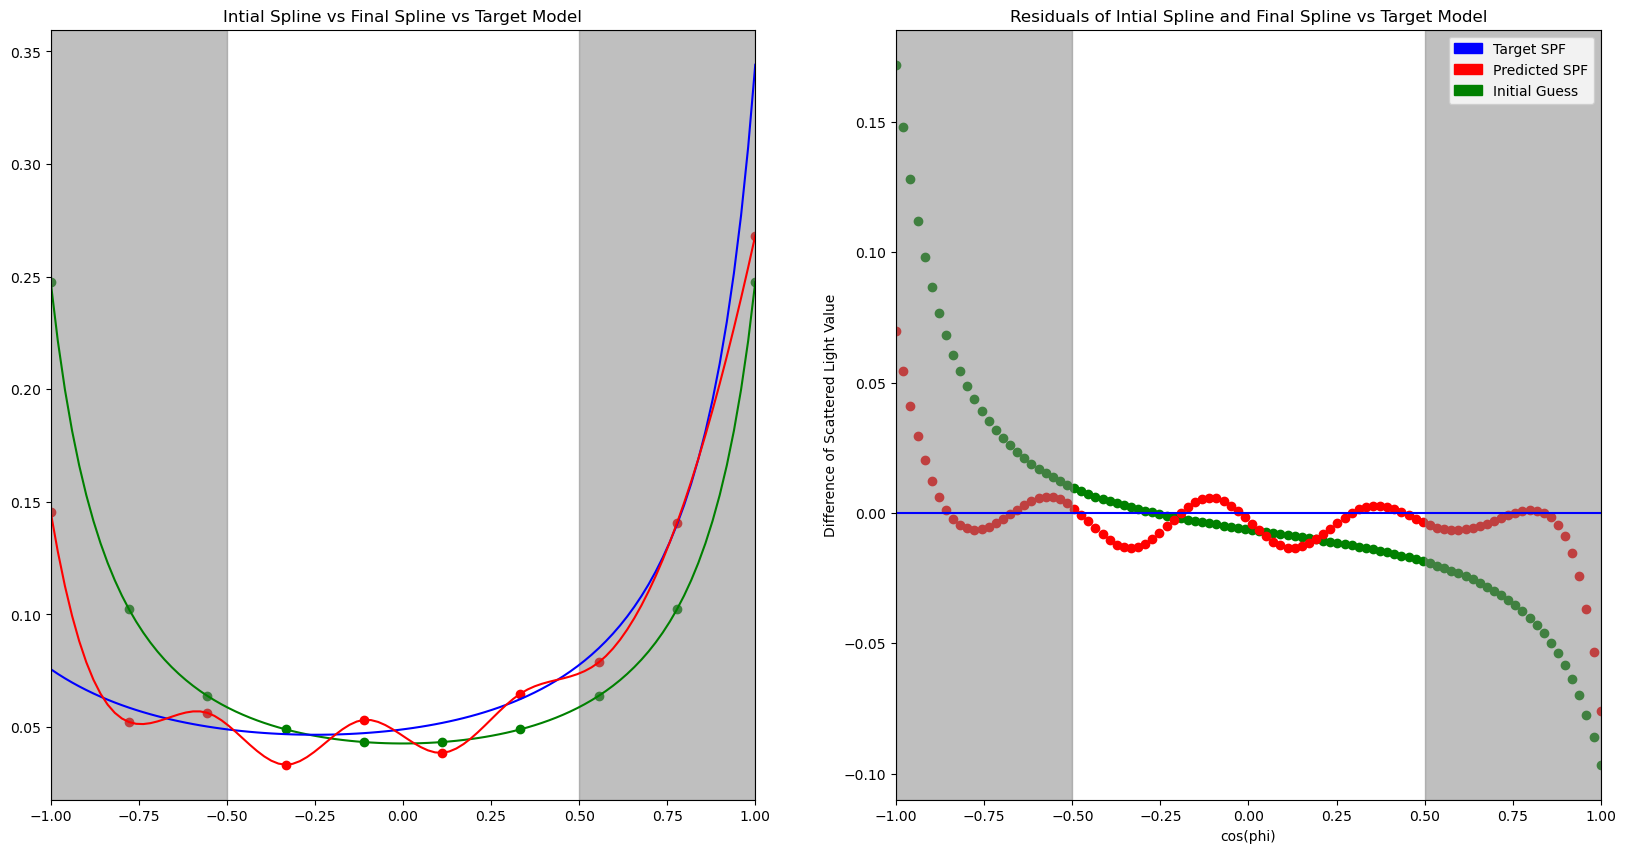

In [17]:
# DHG parameters
spf_params = {'g1': 0.5, 'g2': -0.3, 'weight': 0.7}


# Initial spline guess
init_spf_params = {'g1': 0.5, 'g2': -0.5, 'weight': 0.5}
init_spf = DoubleHenyeyGreenstein_SPF.init([init_spf_params['g1'], init_spf_params['g2'], init_spf_params['weight']])
init_x = np.linspace(np.cos(0), np.cos(np.pi), KNOTS)
init_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_x)
init_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
init_ys = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_xs)

tar_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
tar_x = np.linspace(np.cos(0), np.cos(np.pi), 100)
tar_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(tar_spf, tar_x)

# spf_params_nm
spline_model = InterpolatedUnivariateSpline_SPF.init(spf_params_nm)
fin_x = np.linspace(np.cos(0), np.cos(np.pi), KNOTS)
fin_y = spline_model(fin_x)
fin_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
fin_ys = spline_model(fin_xs)

fig, axes = plt.subplots(1,2, figsize=(20,10))

# Creating legend with color box 
blue_patch = mpatches.Patch(color='blue', label='Target SPF')
red_patch = mpatches.Patch(color='red', label='Predicted SPF')
green_patch = mpatches.Patch(color='green', label='Initial Guess')
plt.legend(handles=[blue_patch, red_patch, green_patch])

axes[0].set_title("Intial Spline vs Final Spline vs Target Model")
axes[0].scatter(init_x, init_y, color = 'g')
axes[0].plot(init_xs, init_ys, color = 'g')
axes[0].plot(tar_x, tar_y, color = 'b')
axes[0].scatter(fin_x, fin_y, color = 'r')
axes[0].plot(fin_xs, fin_ys, color = 'r')
axes[0].axvspan(-1, np.cos((180-disk_params2['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[0].axvspan(np.cos(disk_params2['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[0].set_xlim(-1, 1)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Scattered Light Value")

axes[1].set_title("Residuals of Intial Spline and Final Spline vs Target Model")
axes[1].scatter(init_xs, init_ys-tar_y, color = 'g')
axes[1].scatter(fin_xs, fin_ys-tar_y, color = 'r')
axes[1].axvspan(-1, np.cos((180-disk_params2['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[1].axvspan(np.cos(disk_params2['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[1].set_xlim(-1, 1)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Difference of Scattered Light Value")
axes[1].hlines(0, -1, 1, color = 'b')

plt.show()

### Optimizing with Inclination Bounds

In [18]:
llp_inc = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                    disk_params2["flux_scaling"], target_image, jnp.ones(disk_image2.shape)*noise_level, inc=np.pi/180*disk_params2['inclination'])

no_grad_method = "Nelder-Mead"
soln_nm = minimize(llp_inc, all_pars, method=no_grad_method)
disk_fit_nm = convert_to_dict(soln_nm.x)

opt = {'disp':True,'maxiter':500}
soln_go = minimize(llp_inc, all_pars, options=opt, method = None)
disk_fit_go = convert_to_dict(soln_go.x)

print(soln_nm)

         Current function value: 106622.718750
         Iterations: 75
         Function evaluations: 3190
         Gradient evaluations: 187
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 96096.078125
             x: [ 4.329e+00 -3.092e+00 ...  1.496e-01  3.216e-01]
           nit: 1948
          nfev: 2704
 final_simplex: (array([[ 4.329e+00, -3.092e+00, ...,  1.496e-01,
                         3.216e-01],
                       [ 4.329e+00, -3.092e+00, ...,  1.496e-01,
                         3.216e-01],
                       ...,
                       [ 4.329e+00, -3.092e+00, ...,  1.496e-01,
                         3.216e-01],
                       [ 4.329e+00, -3.092e+00, ...,  1.496e-01,
                         3.216e-01]], dtype=float32), array([ 9.610e+04,  9.610e+04, ...,  9.610e+04,  9.610e+04]))


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [19]:
disk_fit_nm = convert_to_dict(soln_nm.x[0:5])
spf_params_nm = soln_nm.x[5:]

disk_fit_go = convert_to_dict(soln_go.x[0:5])
spf_params_go = soln_go.x[5:]

disk_image1_ap = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_params1, spf_params=params)

disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_fit_nm,
                               spf_params=spf_params_nm)
disk_image_fit_go = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_fit_go,
                               spf_params=spf_params_go)

In [20]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm) + str(soln_nm.x[5:]))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_spline(soln_nm.x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
#print("Gradient Optimization Disk Parameters: " + str(disk_fit_go) + str(soln_go.x[5:]))
#print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_spline(soln_go.x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
#                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 16.007849, 'position_angle': 29.611565, 'alpha_in': 4.3288274, 'alpha_out': -3.091897, 'flux_scaling': 1000000.0, 'sma': 22.29322}[ 0.5932021   0.18734667  0.02509522  0.06527613  0.06752309 -0.07138832
  0.11936983 -0.07470807  0.14962272  0.32158682]
Log-Likelihood: 102716.54
Actual Disk Parameters: {'inclination': 60.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}{'g1': 0.5, 'g2': -0.3, 'weight': 0.7}
Log-Likelihood: 86624.55


Text(0.5, 1.0, 'Grad Optimized Disk')

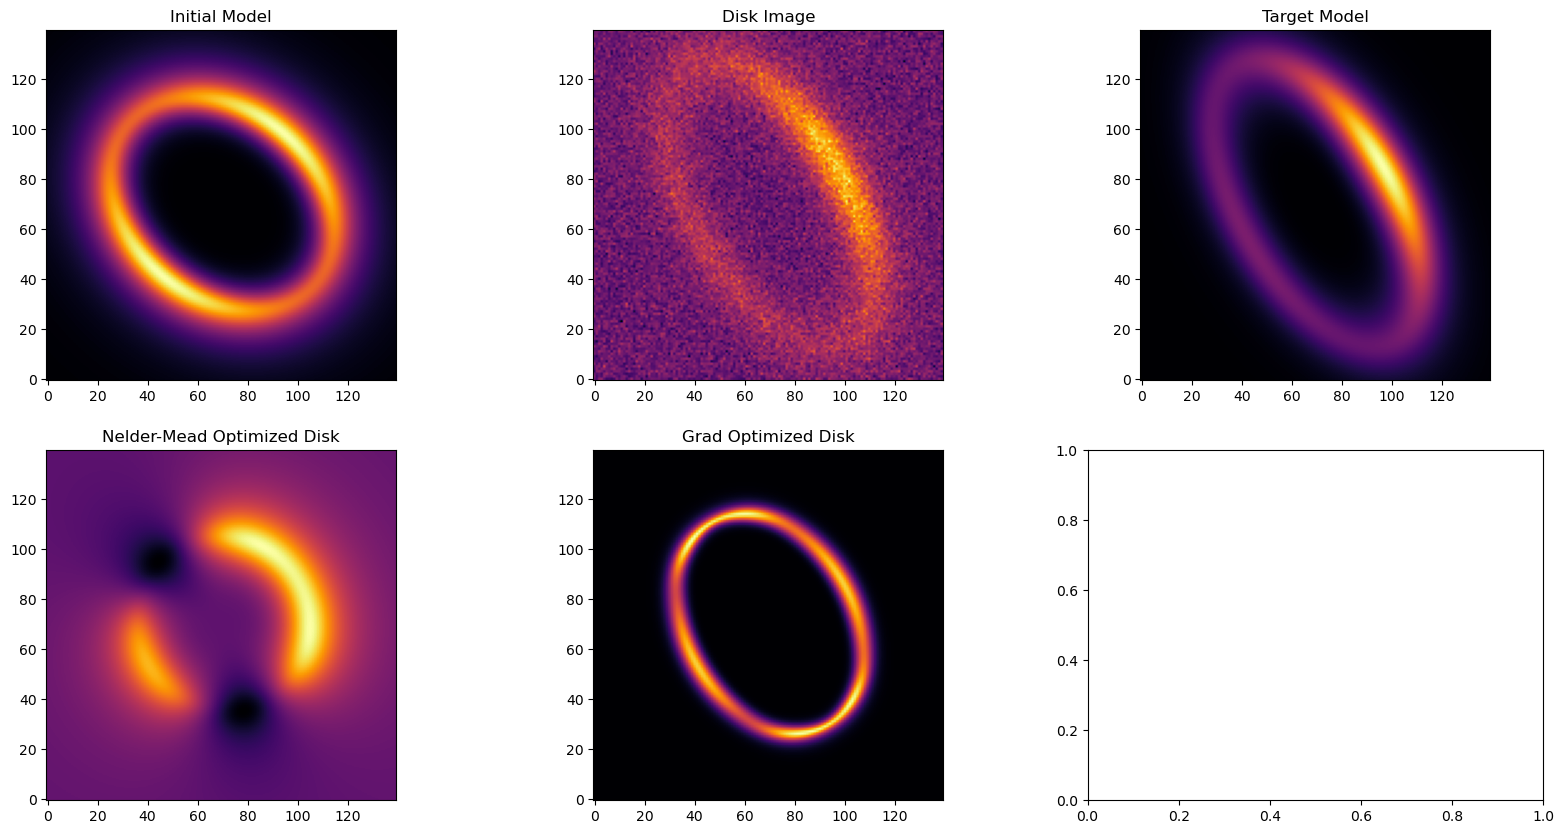

In [21]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

axes[0][0].imshow(disk_image1_ap, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[0][2].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0][2].set_title("Target Model")

axes[1][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[1][0].set_title("Nelder-Mead Optimized Disk")

axes[1][1].imshow(disk_image_fit_go, origin='lower', cmap='inferno')
axes[1][1].set_title("Grad Optimized Disk")

In [22]:
def nelder_mead_test():
    soln = minimize(llp_inc, all_pars, method="Nelder-Mead")
    
def gradient_optimization_test():
    soln = minimize(llp_inc, all_pars, method=None)

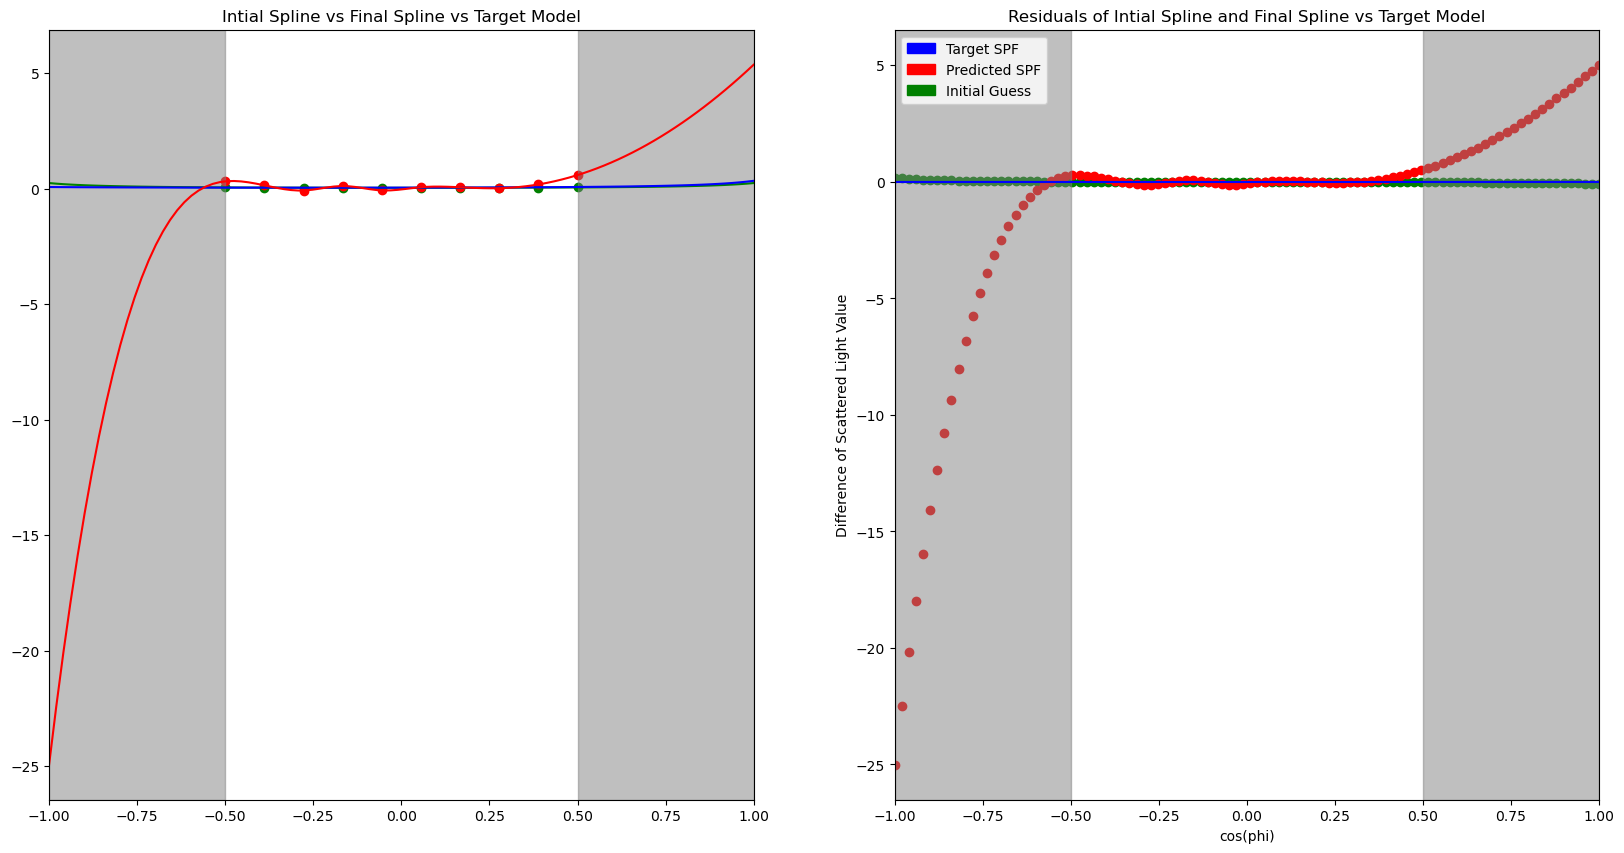

In [23]:
# DHG parameters
spf_params = {'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

inc = disk_params2['inclination']

# Initial spline guess
init_spf_params = {'g1': 0.5, 'g2': -0.5, 'weight': 0.5}
init_spf = DoubleHenyeyGreenstein_SPF.init([init_spf_params['g1'], init_spf_params['g2'], init_spf_params['weight']])
init_x = np.linspace(np.cos(np.pi/180*inc), np.cos(np.pi-(np.pi/180*inc)), KNOTS)
init_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_x)
init_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
init_ys = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_xs)

tar_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
tar_x = np.linspace(np.cos(0), np.cos(np.pi), 100)
tar_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(tar_spf, tar_x)

# spf_params_nm
spline_model = InterpolatedUnivariateSpline_SPF.init(spf_params_nm, inc = np.pi/180*inc)
fin_x = np.linspace(np.cos(np.pi/180*inc), np.cos(np.pi-(np.pi/180*inc)), KNOTS)
fin_y = spline_model(fin_x)
fin_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
fin_ys = spline_model(fin_xs)


fig, axes = plt.subplots(1,2, figsize=(20,10))

# Creating legend with color box 
blue_patch = mpatches.Patch(color='blue', label='Target SPF')
red_patch = mpatches.Patch(color='red', label='Predicted SPF')
green_patch = mpatches.Patch(color='green', label='Initial Guess')
plt.legend(handles=[blue_patch, red_patch, green_patch]) 

axes[0].set_title("Intial Spline vs Final Spline vs Target Model")
axes[0].scatter(init_x, init_y, color = 'g')
axes[0].plot(init_xs, init_ys, color = 'g')
axes[0].plot(tar_x, tar_y, color = 'b')
axes[0].scatter(fin_x, fin_y, color = 'r')
axes[0].plot(fin_xs, fin_ys, color = 'r')
axes[0].axvspan(-1, np.cos((180-disk_params2['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[0].axvspan(np.cos(disk_params2['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[0].set_xlim(-1, 1)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Scattered Light Value")

axes[1].set_title("Residuals of Intial Spline and Final Spline vs Target Model")
axes[1].scatter(init_xs, init_ys-tar_y, color = 'g')
axes[1].scatter(fin_xs, fin_ys-tar_y, color = 'r')
axes[1].axvspan(-1, np.cos((180-disk_params2['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[1].axvspan(np.cos(disk_params2['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[1].set_xlim(-1, 1)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Difference of Scattered Light Value")
axes[1].hlines(0, -1, 1, color = 'b')

plt.show()

## New Interpolation Function

In [24]:

# DHG parameters
spf_params = {'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

# Initial spline guess
init_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
x = np.linspace(np.cos(0), np.cos(np.pi), KNOTS)
y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, x)

# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedMapSpline_SPF, disk_params = disk_params1, spf_params = y)
end = datetime.now()
time1 = end-start
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params2, spf_params = spf_params)
end = datetime.now()
print(end-start)

0:00:04.305872
0:00:00.001361


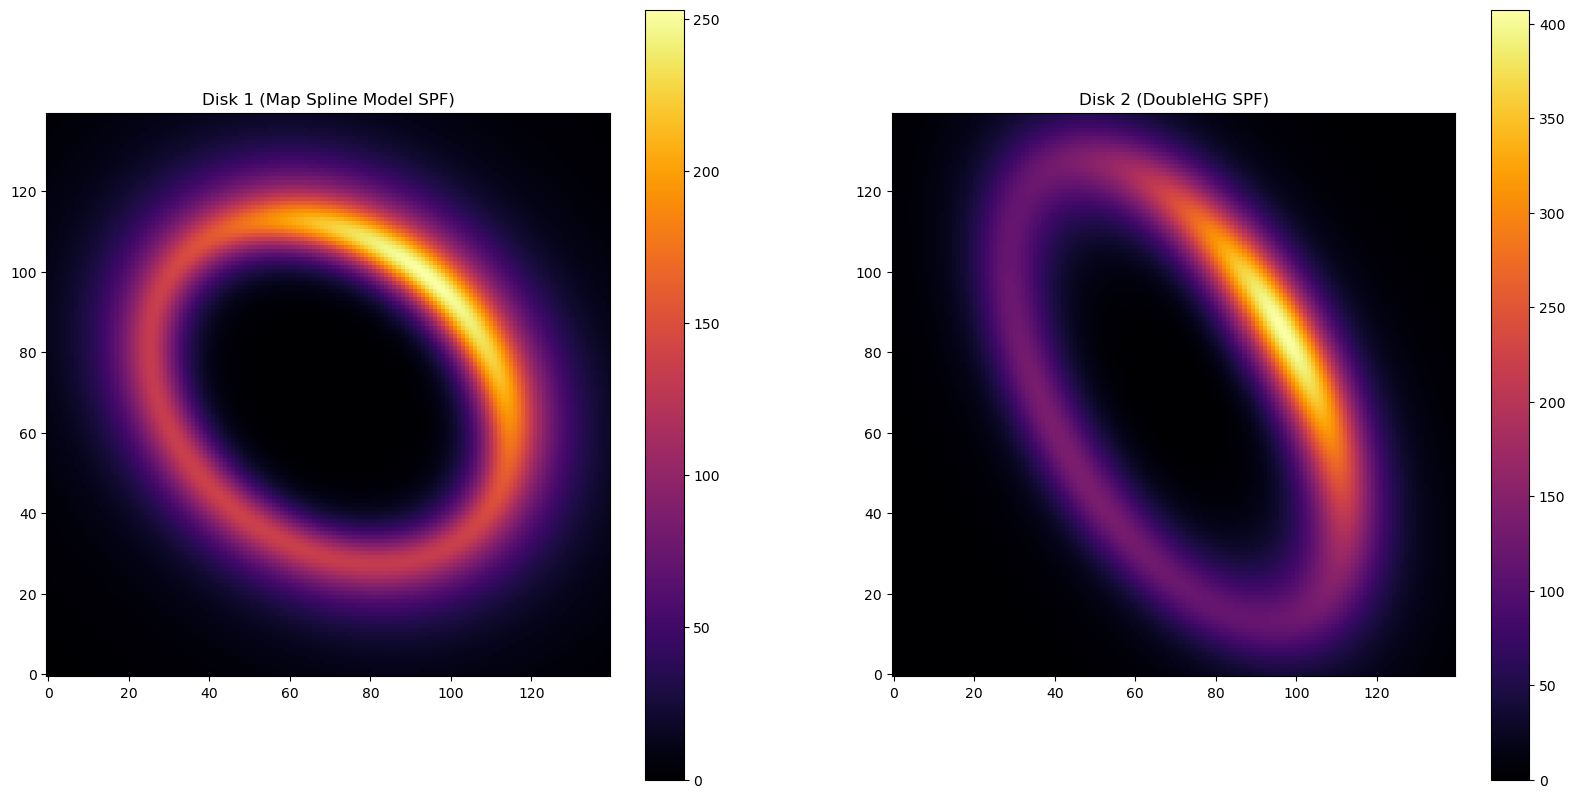

In [25]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Map Spline Model SPF)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (DoubleHG SPF)")
plt.colorbar(im,ax=axes[1])

In [26]:
def test_univ_spline_function():
    jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params = disk_params1, spf_params = y)

def test_map_spline_function():
    jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params = disk_params1, spf_params = y)

def test_DHG_function():
    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params = disk_params1, spf_params = spf_params)

In [27]:
%timeit test_univ_spline_function()
%timeit test_map_spline_function()
%timeit test_DHG_function()

2.48 ms ± 636 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.48 ms ± 586 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
140 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
llp = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedMapSpline_SPF,
                    disk_params2["flux_scaling"], target_image, jnp.ones(disk_image2.shape)*noise_level)

no_grad_method = "Nelder-Mead"
soln_nm = minimize(llp, all_pars, method=no_grad_method)
disk_fit_nm = convert_to_dict(soln_nm.x)

opt = {'disp':True,'maxiter':500}
soln_go = minimize(llp, all_pars, options=opt, method = None)
disk_fit_go = convert_to_dict(soln_go.x)

print(soln_nm)

         Current function value: 98647.843750
         Iterations: 6
         Function evaluations: 1337
         Gradient evaluations: 78
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 86618.671875
             x: [ 5.048e+00 -7.021e+00 ...  5.573e-02  9.274e-02]
           nit: 1962
          nfev: 2742
 final_simplex: (array([[ 5.048e+00, -7.021e+00, ...,  5.573e-02,
                         9.274e-02],
                       [ 5.048e+00, -7.021e+00, ...,  5.573e-02,
                         9.274e-02],
                       ...,
                       [ 5.048e+00, -7.021e+00, ...,  5.573e-02,
                         9.274e-02],
                       [ 5.048e+00, -7.021e+00, ...,  5.573e-02,
                         9.274e-02]], dtype=float32), array([ 8.662e+04,  8.662e+04, ...,  8.662e+04,  8.662e+04]))


/home/mihirkondapalli/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [29]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm) + str(soln_nm.x[5:]))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_spline(soln_nm.x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
#print("Gradient Optimization Disk Parameters: " + str(disk_fit_go) + str(soln_go.x[5:]))
#print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars_spline(soln_go.x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
#                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 60.089935, 'position_angle': 30.022116, 'alpha_in': 5.0481644, 'alpha_out': -7.0213633, 'flux_scaling': 1000000.0, 'sma': 40.06452}[0.25609294 0.14391276 0.0804038  0.06720432 0.05015942 0.05237563
 0.03869915 0.05179261 0.05572665 0.09273575]
Log-Likelihood: 86623.78
Actual Disk Parameters: {'inclination': 60.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}{'g1': 0.5, 'g2': -0.3, 'weight': 0.7}
Log-Likelihood: 86624.55


In [30]:
disk_fit_nm = convert_to_dict(soln_nm.x[0:5])
spf_params_nm = soln_nm.x[5:]

disk_fit_go = convert_to_dict(soln_go.x[0:5])
spf_params_go = soln_go.x[5:]

disk_image1_ap = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_params1, spf_params=params)

disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_fit_nm,
                               spf_params=spf_params_nm)
disk_image_fit_go = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params=disk_fit_go,
                               spf_params=spf_params_go)

Text(0.5, 1.0, 'Grad Optimized Disk')

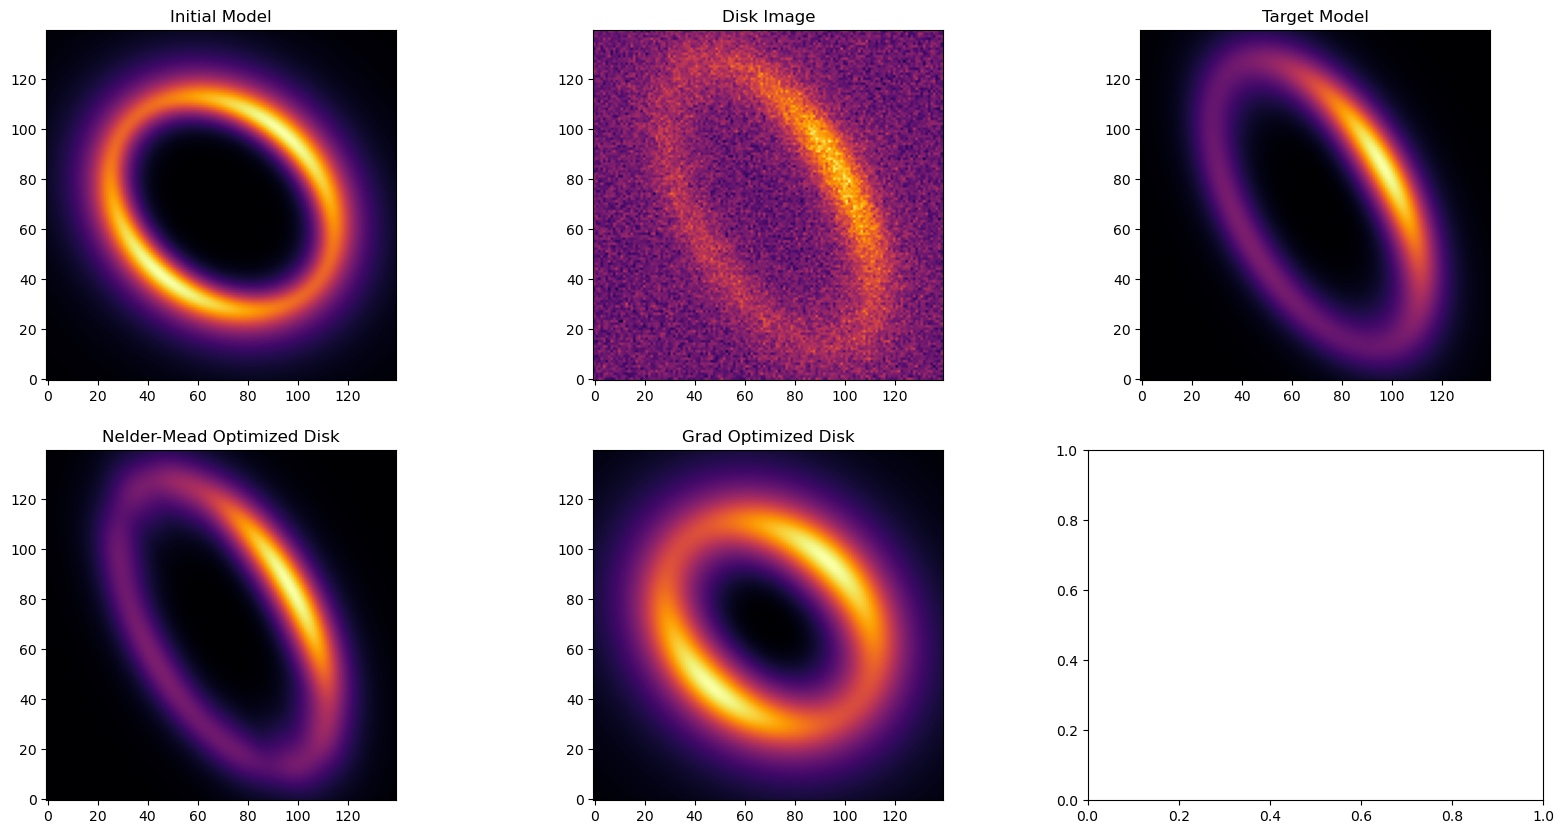

In [31]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

axes[0][0].imshow(disk_image1_ap, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[0][2].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0][2].set_title("Target Model")

axes[1][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[1][0].set_title("Nelder-Mead Optimized Disk")

axes[1][1].imshow(disk_image_fit_go, origin='lower', cmap='inferno')
axes[1][1].set_title("Grad Optimized Disk")

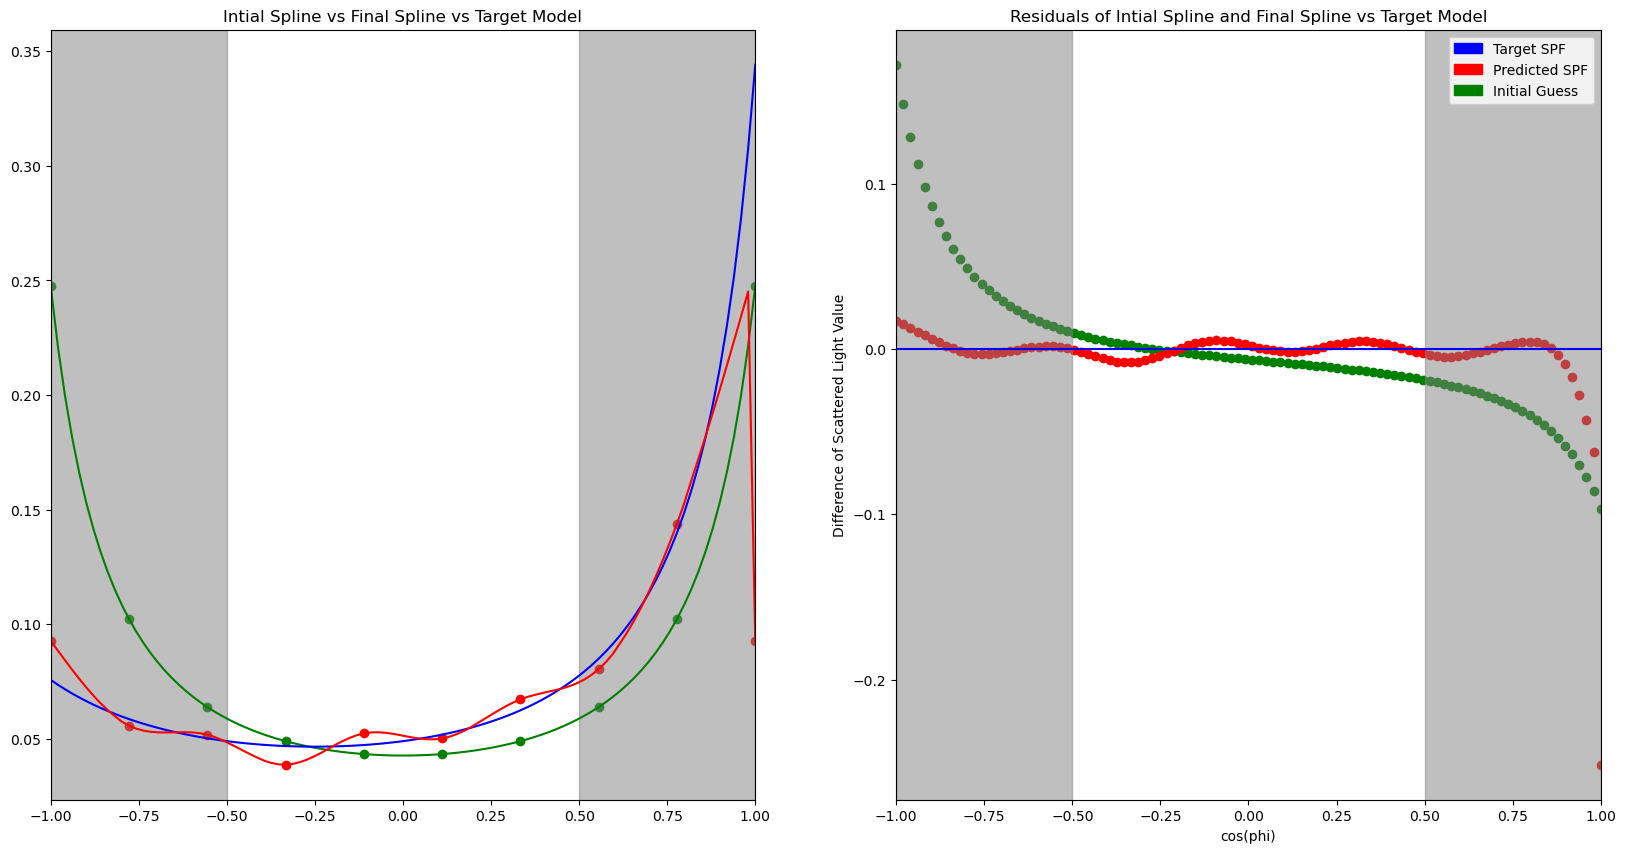

In [32]:
# DHG parameters
spf_params = {'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

inc = disk_params2['inclination']

# Initial spline guess
init_spf_params = {'g1': 0.5, 'g2': -0.5, 'weight': 0.5}
init_spf = DoubleHenyeyGreenstein_SPF.init([init_spf_params['g1'], init_spf_params['g2'], init_spf_params['weight']])
init_x = np.linspace(np.cos(0), np.cos(np.pi), KNOTS)
init_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_x)
init_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
init_ys = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(init_spf, init_xs)

tar_spf = DoubleHenyeyGreenstein_SPF.init([spf_params['g1'], spf_params['g2'], spf_params['weight']])
tar_x = np.linspace(np.cos(0), np.cos(np.pi), 100)
tar_y = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi(tar_spf, tar_x)

# spf_params_nm
spline_model = InterpolatedMapSpline_SPF.init(spf_params_nm)
fin_x = np.linspace(np.cos(0), np.cos(np.pi), KNOTS)
fin_y = InterpolatedMapSpline_SPF.compute_phase_function_from_cosphi(spline_model, fin_x)
fin_xs = np.linspace(np.cos(0), np.cos(np.pi), 100)
fin_ys = InterpolatedMapSpline_SPF.compute_phase_function_from_cosphi(spline_model, fin_xs)


fig, axes = plt.subplots(1,2, figsize=(20,10))

# Creating legend with color box 
blue_patch = mpatches.Patch(color='blue', label='Target SPF')
red_patch = mpatches.Patch(color='red', label='Predicted SPF')
green_patch = mpatches.Patch(color='green', label='Initial Guess')
plt.legend(handles=[blue_patch, red_patch, green_patch]) 

axes[0].set_title("Intial Spline vs Final Spline vs Target Model")
axes[0].scatter(init_x, init_y, color = 'g')
axes[0].plot(init_xs, init_ys, color = 'g')
axes[0].plot(tar_x, tar_y, color = 'b')
axes[0].scatter(fin_x, fin_y, color = 'r')
axes[0].plot(fin_xs, fin_ys, color = 'r')
axes[0].axvspan(-1, np.cos((180-disk_params2['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[0].axvspan(np.cos(disk_params2['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[0].set_xlim(-1, 1)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Scattered Light Value")

axes[1].set_title("Residuals of Intial Spline and Final Spline vs Target Model")
axes[1].scatter(init_xs, init_ys-tar_y, color = 'g')
axes[1].scatter(fin_xs, fin_ys-tar_y, color = 'r')
axes[1].axvspan(-1, np.cos((180-disk_params2['inclination'])*np.pi/180), color='grey', alpha=0.5)
axes[1].axvspan(np.cos(disk_params2['inclination']*np.pi/180), 1, color='grey', alpha=0.5)
axes[1].set_xlim(-1, 1)
axes[1].set_xlabel("cos(phi)")
axes[1].set_ylabel("Difference of Scattered Light Value")
axes[1].hlines(0, -1, 1, color = 'b')

plt.show()

## Comparing Optimization Fits and Runtimes

In [33]:
llp = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                    disk_params2["flux_scaling"], target_image, jnp.ones(disk_image2.shape)*noise_level)

llp_inc = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                    disk_params2["flux_scaling"], target_image, jnp.ones(disk_image2.shape)*noise_level, inc=np.pi/180*disk_params2['inclination'])

llp_map = lambda x: log_likelihood_1d_pos_all_pars_spline(x, DustEllipticalDistribution2PowerLaws, InterpolatedMapSpline_SPF,
                    disk_params2["flux_scaling"], target_image, jnp.ones(disk_image2.shape)*noise_level)

# No grad method is nelder mead

def univ_spline_opt():
    return minimize(llp, all_pars, method = no_grad_method)

def univ_spline_opt_inc_bounds():
    return minimize(llp_inc, all_pars, method = no_grad_method)

def map_spline_opt():
    return minimize(llp, all_pars, method = no_grad_method)

In [34]:
print('Positive Log-Likelihood (lower is better)')
print('Univariate Spline: ' + str(llp(univ_spline_opt().x)))
print('Univatiate Spline (With inclination bounds): ' + str(llp_inc(univ_spline_opt_inc_bounds().x)))
print('Map Spline: ' + str(llp_map(map_spline_opt().x)))

Positive Log-Likelihood (lower is better)


Univariate Spline: 86662.85
Univatiate Spline (With inclination bounds): 96096.08
Map Spline: 86716.67


In [35]:
%timeit univ_spline_opt()
%timeit univ_spline_opt_inc_bounds()
%timeit map_spline_opt()

8.04 s ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.25 s ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.03 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
